In [64]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import mplfinance as mpf

In [80]:
class ticker_Data:
    def __init__(self, ticker:str, start_date:str, in_price: float, tgt_price: float, sl_price: float, interval: str='1h', duration: int = 60):
        self.ticker = ticker
        self.start_date = start_date
        self.start_date_ts = datetime.strptime(start_date, "%Y-%m-%d")
        self.end_date = (self.start_date_ts + timedelta(days=duration)).strftime("%Y-%m-%d")
        self.interval = interval
        self.duration = duration
        self.in_price = in_price
        self.tgt_price = tgt_price
        self.sl_price = sl_price
        self.outcome = {}
        self.outcome_price = in_price
        self.return_rate = 0.0
        self.return_horizon = duration

    def get_price_data(self) -> pd.DataFrame:
        try:
            df = yf.download(tickers=self.ticker, start=self.start_date, end=self.end_date, interval=self.interval, auto_adjust=True, multi_level_index=False, rounding=True, actions=True)
            return df
        except Exception as e:
            print(f'Could not get data for ticker: {self.ticker}')
            return None

    def simple_win_or_loss(self, action: pd.DataFrame) -> dict:
        # set both timers to start index
        #start_ts = win_ts = lose_ts = action.index[0]
        
        win_br = []
        lose_br = []
        
        for idx, row in action.iterrows():
            if row['High']>=self.tgt_price:  #Did any highest high touch tgt
                win_br.append(idx)
                
            if row['Low']<=self.sl_price: # Did any lowest low touch sl
                lose_br.append(idx)
                
        if len(win_br)>0 and len(lose_br)>0 and win_br[0]<lose_br[0]:
            # Stock did random walk, touched both limits, but touched tgt before it touched sl 
            outcome = {'result':'win', 'index':win_br[0]}
            self.outcome = outcome
            self.outcome_price = action.loc[win_br[0], 'High']
            return outcome
            
        if len(win_br)>0 and len(lose_br)==0:
            # stock only stayed above sl and trouched tgt
            outcome = {'result':'win', 'index':win_br[0]}
            self.outcome = outcome
            self.outcome_price = action.loc[win_br[0], 'High']
            return outcome
        
        if len(win_br)>0 and len(lose_br)>0 and win_br[0]>lose_br[0]:
            # Stock did random walk, touched both limits, but touched sl before it touched tgt 
            outcome = {'result':'lose', 'index':lose_br[0]}
            self.outcome = outcome
            self.outcome_price = action.loc[lose_br[0], 'Low']
            return outcome
                
        if len(lose_br)>0 and len(win_br)==0:
            # stcok only went down and touched sl but never touched tgt
            outcome = {'result':'lose', 'index':lose_br[0]}
            self.outcome_price = action.loc[lose_br[0], 'Low']
            self.outcome = outcome
            return outcome

        outcome = {'result': 'undet', 'index':action.index[len(action)-1]}
        self.outcome = outcome
        return outcome

In [88]:
#ticker = ticker_Data(ticker='MALUPAPER.NS', start_date='2024-12-03', in_price=52.96, tgt_price=57.0, sl_price=51.0, duration=60)
#ticker = ticker_Data(ticker='PREMIERPOL.NS', start_date='2025-01-01', in_price=73.9, tgt_price=81.0, sl_price=71.0, duration=60)
ticker = ticker_Data(ticker='ASALCBR.NS', start_date='2025-01-01', in_price=1103.25, tgt_price=1170.0, sl_price=1065.0, duration=60)
#344.65	369	333 1335	1429	1228 1103.25	1170	1065
prices = ticker.get_price_data()
prices.index = prices.index.tz_convert('Asia/Kolkata')
outcome = ticker.simple_win_or_loss(prices)
ticker.return_rate = (ticker.outcome_price/ticker.in_price - 1) * 100
ticker.return_horizon = (ticker.outcome.get('index').replace(tzinfo=None) - ticker.start_date_ts).days
print(f'''{ticker.outcome.get('result')}: {ticker.ticker} returned {ticker.return_rate:.2f}% in {ticker.return_horizon} days from {ticker.in_price} to {ticker.outcome_price} with investment on {ticker.start_date}.''')

[*********************100%***********************]  1 of 1 completed

win: ASALCBR.NS returned 8.09% in 7 days from 1103.25 to 1192.45 with investment on 2025-01-01.


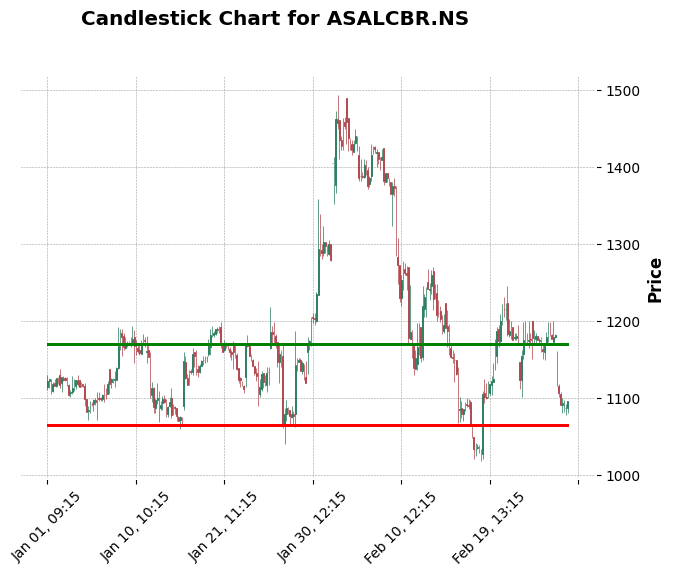

In [89]:
levels = [[(prices.index[0], ticker.sl_price), (prices.index[len(prices)-1], ticker.sl_price)], [(prices.index[0], ticker.tgt_price), (prices.index[len(prices)-1], ticker.tgt_price)]]
mpf.plot(prices, type='candle', 
         volume=False, title=f'Candlestick Chart for {ticker.ticker}', style='charles', 
         alines=dict(alines=levels, colors=['r','g'])
        )
         #hlines=[(ticker.sl_price, 'red', 'Level1'), (ticker.tgt_price, 'blue', 'Level2')])